**Some examples of science/systems validation. Can be applied to daily ERA-5/CMIP6 files, bias corrected and downscaled data.**

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime, timedelta, date

import dask
import dask.array as dda
import dask.distributed as dd

# rhodium-specific kubernetes cluster configuration
import rhg_compute_tools.kubernetes as rhgk

In [2]:
client, cluster = rhgk.get_big_cluster()
cluster.scale(30)

In [3]:
client

Client Scheduler: gateway://traefik-impactlab-hub-dask-gateway.impactlab-hub:80/impactlab-hub.51e76f2aea314dd88704e35b1eee1fb8 Dashboard: /services/dask-gateway/clusters/impactlab-hub.51e76f2aea314dd88704e35b1eee1fb8/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [58]:
cluster.close()

System validation checks 

In [7]:
def test_for_nans(ds, var):
    # no nans
    assert ds[var].isnull().sum() == 0, "there are nans!"

def test_num_days(ds):
    # num timesteps = 1
    assert (len(ds.time) == 365 or len(ds.time) == 366), "there are not 365 or 366 days in this file!"
    
def test_temp_range(ds, var):
    # make sure temp values are in a valid range
    # asserts if statement below is false
    assert (ds[var].min() > 150) or (ds[var].max() < 350), "temperature values are invalid" 

def test_negative_precip(ds, var):
    threshold = 0.0
    location = ds[var].where(ds[var] < threshold)
    num = np.count_nonzero(~np.isnan(location))
    return num

def test_maximum_precip(ds, var):
    threshold = 1.0 # max observed is 1.825m --> maximum occurs between 0.5-0.8
    location = ds[var].where(ds[var] > threshold)
    num = np.count_nonzero(~np.isnan(location))
    return num

def validate_era5_files(spec):
    '''
    validate ERA-5 daily  files. 
    '''
    filepath, timestep, var = spec
    
    # first check to be sure file exists
    if os.path.isfile(filepath):
        pass
    else:
        raise FileNotFoundError("%s was not created" %filepath)
    # now validate
    with xr.open_dataset(filepath) as ds:
        test_for_nans(ds, var)
        
        if timestep == 'daily':
            test_num_days(ds)
            
        if var == ['tas', 'tmax', 'tmin']:
            test_temp_range(ds, var)
        elif var == 'precip_total':
            negative_occurrances = test_negative_precip(ds, var)
            if negative_occurrances > 0:
                return [negative_occurrances, filepath]

            max_occurrances = test_maximum_precip(ds, var)
            if max_occurrances > 0:
                return [max_occurrances, filepath]

In [6]:
era_start = '1979'
era_end = '2020'

# make list of yearly datetime indices, this includes leap years 
dt_index_full = pd.date_range(start=era_start, end=era_end, freq='Y')

# reformat month/day for the retrieval function 
dt_index_years = dt_index_full.year.astype(str)

In [8]:
var = 'tas' #precip_total

yearly_files = ['%s_daily_%s-%s.nc' %(var, year, year) for year in dt_index_years] 
daily_dir = '/gcs/impactlab-data/climate/source_data/ERA-5/{}/daily/netcdf_files/v1.1'.format(var)

daily_filepaths = [os.path.join(daily_dir, yearly_file) for yearly_file in yearly_files]
JOBS_validation = [(filepath, 'daily', var) for filepath in daily_filepaths]

In [9]:
JOBS_validation[0]

('/gcs/impactlab-data/climate/source_data/ERA-5/tas/daily/netcdf_files/v1.1/tas_daily_1979-1979.nc',
 'daily',
 'tas')

In [10]:
%%time
futures_validation = client.map(validate_era5_files, JOBS_validation)
dd.progress(futures_validation)

CPU times: user 17.2 ms, sys: 2.87 ms, total: 20.1 ms
Wall time: 17.7 ms


VBox()

In [11]:
# gathers output from workers
results = client.gather(futures_validation)

In [12]:
# test number of not None instances in results i.e. where a function 'failed'
print(sum(x is not None for x in results))

0


Global weighted mean calculation

In [22]:
def weighted_masked_mean(da, dim=None, lat_name='latitude',lon_name='longitude'):
    lat_weights = np.cos(da[lat_name] * np.pi/180.)
    weights = xr.ones_like(da) * lat_weights
     
    masked_weights = weights.where(~da.isnull())
    
    normalized_masked_weights = (
        masked_weights / masked_weights.sum(dim=dim))

    return (da*normalized_masked_weights).sum(dim=dim)

def compute_global_avg(year):
    filename = '/gcs/impactlab-data/climate/source_data/ERA-5/{var}/daily/netcdf_files/v1.1/{var}_daily_{yr}-{yr}.nc'.format(var=var,yr=year)
    ds = xr.open_dataset(filename)
    return weighted_masked_mean(ds)

In [14]:
JOBS_gmst = [yr for yr in np.arange(1979,2021)]

In [15]:
%%time
futures_gmst = client.map(compute_global_avg, JOBS_gmst)
dd.progress(futures_gmst)

CPU times: user 17.3 ms, sys: 4.05 ms, total: 21.4 ms
Wall time: 18.7 ms


VBox()

In [16]:
gmst_ds = client.gather(futures_gmst)

In [17]:
year_means_ds = xr.concat(gmst_ds, dim=pd.Index(np.arange(1979,2021),name='year'))

In [18]:
year_means_da = year_means_ds.to_array()
year_means_da

<xarray.DataArray (variable: 1, year: 42)>
array([[287.10275, 287.22546, 287.26657, 287.06506, 287.2592 , 287.04285,
        287.00775, 287.09668, 287.2493 , 287.27896, 287.16562, 287.40005,
        287.3407 , 287.10623, 287.15555, 287.19308, 287.367  , 287.2353 ,
        287.36273, 287.54913, 287.27957, 287.271  , 287.43863, 287.5337 ,
        287.51996, 287.45267, 287.624  , 287.57178, 287.56122, 287.43176,
        287.56265, 287.65848, 287.52094, 287.56348, 287.59622, 287.6351 ,
        287.78494, 287.96283, 287.87448, 287.79163, 287.92712, 287.95767]],
      dtype=float32)
Coordinates:
  * year      (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020
  * variable  (variable) <U3 'tas'

Text(0.5, 0, 'Years')

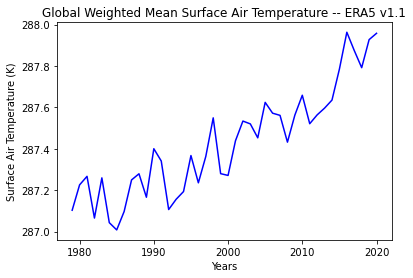

In [19]:
x = range(1979,2021,1)

fig = plt.figure()
plt.plot(x,np.squeeze(year_means_da), 'b-')

plt.title('Global Weighted Mean Surface Air Temperature -- ERA5 v1.1')
plt.ylabel("Surface Air Temperature (K)")
plt.xlabel("Years")

In [4]:
! pip install git+https://github.com/ClimateImpactLab/xclim.git@qdm_add_year_selection

  Cloning https://github.com/ClimateImpactLab/xclim.git (to revision qdm_add_year_selection) to /tmp/pip-req-build-mn3pr18i
  Using cached boltons-20.2.1-py2.py3-none-any.whl (170 kB)
  Using cached cftime-1.4.1-cp38-cp38-manylinux2014_x86_64.whl (322 kB)
  Created wheel for xclim: filename=xclim-0.24.0-py3-none-any.whl size=272391 sha256=196610a26d003b8584b7459682fdfb2f14e6acc3ec7c21d5e89fc7b410128a65
  Stored in directory: /tmp/pip-ephem-wheel-cache-2h2eeolh/wheels/d3/2a/fd/4b118244d4c312a9c161b6964c50e3f3df8091188478abbba0
Successfully built xclim
  Attempting uninstall: cftime
    Found existing installation: cftime 1.3.0
    Uninstalling cftime-1.3.0:
      Successfully uninstalled cftime-1.3.0


In [5]:
def pull_ERA5_variable(variable):
    filenames = []
    
    for num_yrs in range(len(yrs)):
        filename = '/gcs/impactlab-data/climate/source_data/ERA-5/{}/daily/netcdf_files/v1.1/{}_daily_{}-{}.nc'.format(variable, variable, yrs[num_yrs], yrs[num_yrs])
        filenames.append(filename)
    
    era5_var = xr.open_mfdataset(filenames, 
                               concat_dim='time', combine='by_coords')
    
    var_all = era5_var[variable]
    
    return var_all

In [6]:
yrs = np.arange(1979,2021) 

In [7]:
da = pull_ERA5_variable('tas')

In [8]:
from xclim.core.calendar import convert_calendar

# remove leap days and convert calendar to no-leap
da = convert_calendar(da, 'noleap')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [9]:
da = da.persist()

Spatial validation plots for mean, max and min

In [35]:
da_mean = da.mean(dim='time').compute()

In [11]:
from matplotlib import cm
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [18]:
def plot_world(da, title):
    fig = plt.figure(figsize=(10, 3))
    ax = plt.axes(projection=ccrs.Robinson())
    cmap = cm.jet

    da.plot(
        ax=ax,
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "Temperature (K)"}, vmin=230.0, vmax=310.0)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, linestyle=":")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(title)

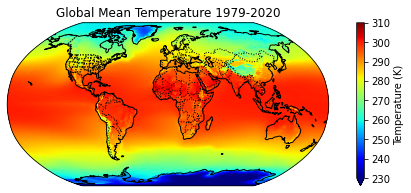

In [19]:
plot_world(da_mean, "Global Mean Temperature 1979-2020")

In [14]:
da_max = da.max(dim='time').compute()

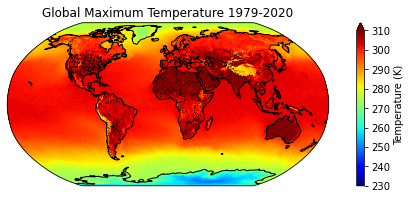

In [20]:
plot_world(da_max, "Global Maximum Temperature 1979-2020")

In [22]:
da_min = da.min(dim='time').compute()

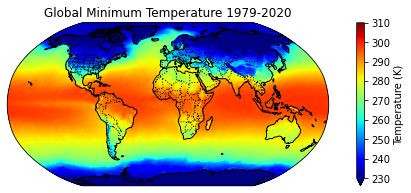

In [23]:
plot_world(da_min, "Global Minimum Temperature 1979-2020")

Histogram for distribution of values (across small number of years)

In [16]:
def hist_plot(da, start_year, end_year):
    da_sel = da.sel(time=slice(start_year,end_year)).persist()
    da_sel.plot.hist(bins=20, rwidth=0.9, color='#0504aa')
    plt.title('Counts of Temperature')
    plt.xlabel('Temp (K)')
    plt.ylabel('Counts')

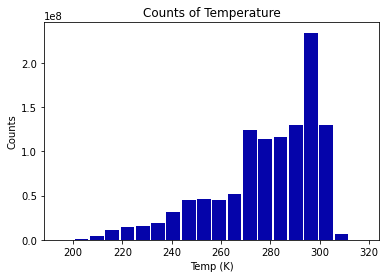

In [17]:
hist_plot(da, '2001', '2003')

Calculating the per year quantile and looking at extreme trends over time

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
def percentile_per_year(da, percentile):
    da_percent = da.groupby('time.year').quantile(percentile).persist()
    return da_percent

In [28]:
da_percentile = percentile_per_year(da, 0.95)

In [20]:
da_percentile

<xarray.DataArray 'tas' (year: 42, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(42, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    quantile   float64 0.95
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2017 2018 2019 2020

In [24]:
weighted_mean_percentile = weighted_masked_mean(da_percentile, ['latitude','longitude'],'latitude','longitude').compute()
weighted_mean_percentile

<xarray.DataArray (year: 42)>
array([293.08868683, 293.18574651, 293.07255333, 293.03228594,
       293.28295228, 293.10272801, 292.95230318, 293.01649503,
       293.20532424, 293.31800676, 293.15457738, 293.31164043,
       293.34308534, 293.05725432, 293.10463463, 293.1989628 ,
       293.31510034, 293.18827004, 293.35266762, 293.64397915,
       293.2153581 , 293.21699139, 293.42424835, 293.47186409,
       293.52186808, 293.3901125 , 293.55339202, 293.49606991,
       293.47039874, 293.34367202, 293.48677317, 293.76047796,
       293.49759347, 293.58850218, 293.61427713, 293.62428773,
       293.72566437, 293.90239633, 293.76785164, 293.69280681,
       293.89791837, 293.89550883])
Coordinates:
    quantile  float64 0.95
  * year      (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020

Text(0.5, 0, 'Years')

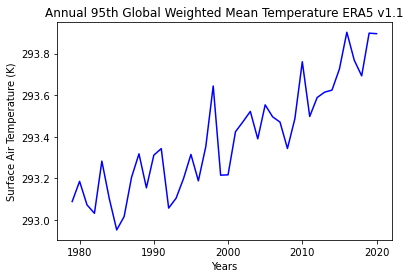

In [25]:
x = range(1979,2021,1)

fig = plt.figure()
plt.plot(x,weighted_mean_percentile, 'b-')

plt.title('Annual 95th Global Weighted Mean Temperature ERA5 v1.1')
plt.ylabel("Surface Air Temperature (K)")
plt.xlabel("Years")